## 1、加载图片路径和标签

In [1]:
import os
import tensorflow as tf
from PIL import Image
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

def load_sample(sample_dir,shuffleflag = True):
    '''递归读取文件。只支持一级。返回文件名、数值标签、数值对应的标签名'''
    print ('loading sample  dataset..')
    lfilenames = []
    labelsnames = []
    for (dirpath, dirnames, filenames) in os.walk(sample_dir):#递归遍历文件夹
        for filename in filenames:                            #遍历所有文件名
            #print(dirnames)
            filename_path = os.sep.join([dirpath, filename])
            lfilenames.append(filename_path)               #添加文件名
            labelsnames.append( dirpath.split('\\')[-1] )#添加文件名对应的标签

    lab= list(sorted(set(labelsnames)))  #生成标签名称列表
    labdict=dict( zip( lab  ,list(range(len(lab)))  )) #生成字典

    labels = [labdict[i] for i in labelsnames]
    if shuffleflag == True:
        return shuffle(np.asarray( lfilenames),np.asarray( labels)),np.asarray(lab)
    else:
        return (np.asarray( lfilenames),np.asarray( labels)),np.asarray(lab)

In [2]:
data_dir =r"./hymenoptera_data/train" #定义文件路径

(image,label),labelsnames = load_sample(data_dir)   #载入文件名称与标签
print(len(image),image[:2],len(label),label[:2])#输出load_sample返回的数据结果
print(labelsnames[ label[:2] ],labelsnames)#输出load_sample返回的标签字符串

loading sample  dataset..
244 ['./hymenoptera_data/train/bees/1097045929_1753d1c765.jpg'
 './hymenoptera_data/train/ants/460874319_0a45ab4d05.jpg'] 244 [1 0]
['./hymenoptera_data/train/bees' './hymenoptera_data/train/ants'] ['./hymenoptera_data/train/ants' './hymenoptera_data/train/bees']


## 2、 Data数据集

In [3]:
def get_batches(image,label,input_w,input_h,channels,batch_size):

    queue = tf.train.slice_input_producer([image,label])  #使用tf.train.slice_input_producer实现一个输入的队列
    label = queue[1]                                        #从输入队列里读取标签

    image_c = tf.read_file(queue[0])                        #从输入队列里读取image路径

    image = tf.image.decode_jpeg(image_c,channels)           #按照路径读取图片

    image = tf.image.resize_image_with_crop_or_pad(image,input_w,input_h) #修改图片大小


    image = tf.image.per_image_standardization(image) #图像标准化处理，(x - mean) / adjusted_stddev

    image_batch,label_batch = tf.train.batch([image,label],#调用tf.train.batch函数生成批次数据
               batch_size = batch_size,
               num_threads = 64)

    images_batch = tf.cast(image_batch,tf.float32)   #将数据类型转换为float32

    labels_batch = tf.reshape(label_batch,[batch_size])#修改标签的形状shape
    return images_batch,labels_batch

W0205 08:17:16.170320 140184911034112 deprecation.py:323] From <ipython-input-3-1500b7a66ce7>:3: slice_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0205 08:17:16.191329 140184911034112 deprecation.py:323] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/input.py:374: range_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0205 08:17:16.195355 14018491103411

0


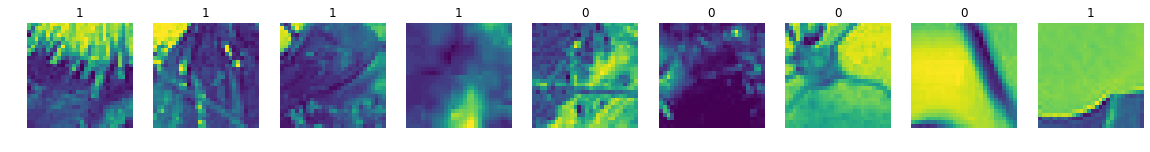

[1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0]
1


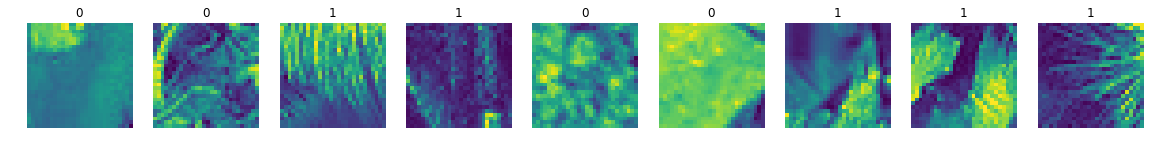

[0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1]
2


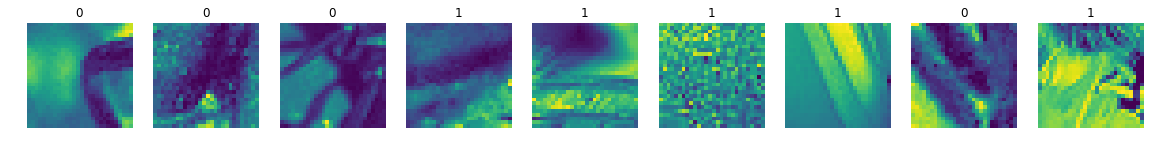

[0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0]
3


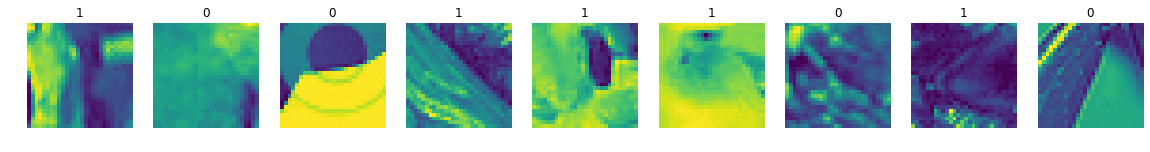

[1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0]
4


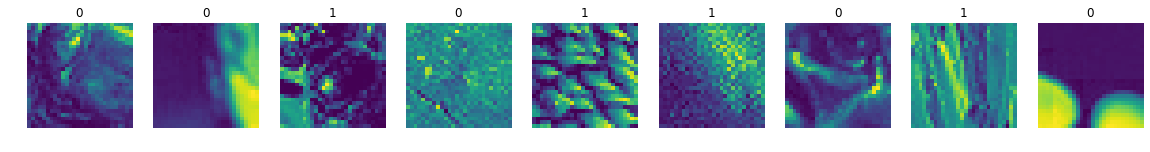

[0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1]
5


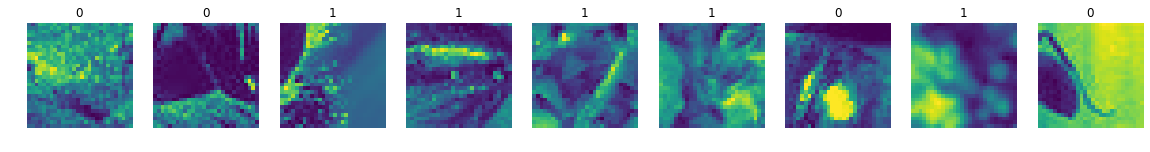

[0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1]
6


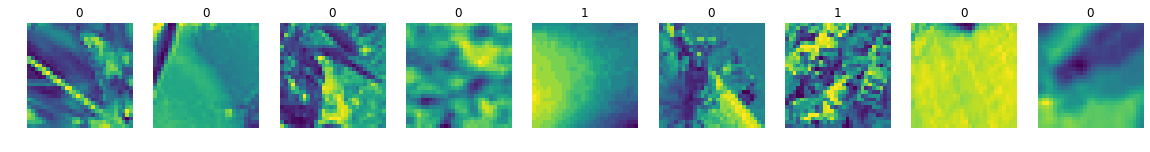

[0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
7


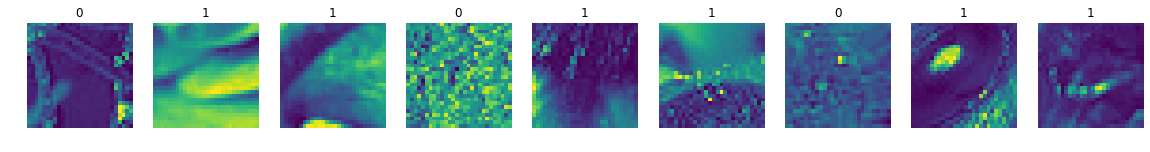

[0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0]
8


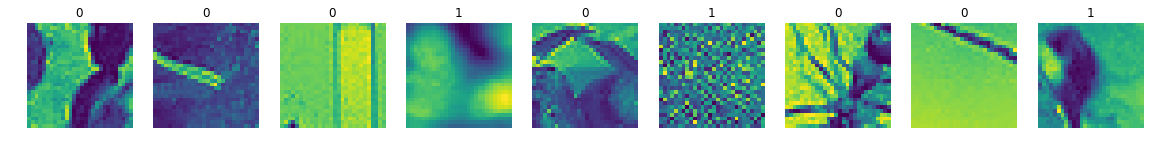

[0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1]
9


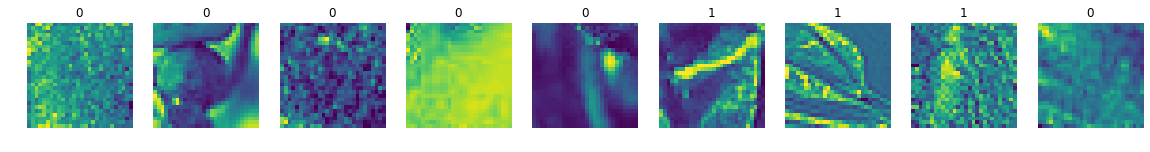

[0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1]


In [4]:
batch_size = 16
image_batches,label_batches = get_batches(image,label,28,28,1,batch_size)



def showresult(subplot,title,thisimg):          #显示单个图片
    p =plt.subplot(subplot)
    p.axis('off')
    #p.imshow(np.asarray(thisimg[0], dtype='uint8'))
    p.imshow(np.reshape(thisimg, (28, 28)))
    p.set_title(title)

def showimg(index,label,img,ntop):   #显示
    plt.figure(figsize=(20,10))     #定义显示图片的宽、高
    plt.axis('off')
    ntop = min(ntop,9)
    print(index)
    for i in range (ntop):
        showresult(100+10*ntop+1+i,label[i],img[i])
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)  #初始化

    coord = tf.train.Coordinator()          #开启列队
    threads = tf.train.start_queue_runners(sess = sess,coord = coord)
    try:
        for step in np.arange(10):
            if coord.should_stop():
                break
            images,label = sess.run([image_batches,label_batches]) #注入数据

            showimg(step,label,images,batch_size)       #显示图片
            print(label)                                 #打印数据

    except tf.errors.OutOfRangeError:
        print("Done!!!")
    finally:
        coord.request_stop()

    coord.join(threads)                             #关闭列队

# 3、TFRecord加载数据集

In [12]:
def makeTFRec(filenames,labels): #定义函数生成TFRecord
    writer= tf.python_io.TFRecordWriter("mydata.tfrecords") #通过tf.python_io.TFRecordWriter 写入到TFRecords文件
    for i in tqdm( range(0,len(labels) ) ):
        img=Image.open(filenames[i])
        img = img.resize((256, 256))
        img_raw=img.tobytes()#将图片转化为二进制格式
        example = tf.train.Example(features=tf.train.Features(feature={
                #存放图片的标签label
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[labels[i]])),
                #存放具体的图片
                'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
            })) #example对象对label和image数据进行封装

        writer.write(example.SerializeToString())  #序列化为字符串
    writer.close()  #数据集制作完成

data_dir =r"./hymenoptera_data/train" #定义文件路径
(image,label),labelsnames = load_sample(data_dir)   #载入文件名称与标签
makeTFRec(image,label)

  4%|▎         | 9/244 [00:00<00:02, 83.39it/s]

loading sample  dataset..


100%|██████████| 244/244 [00:02<00:00, 82.47it/s]


In [13]:
################将tf数据集转化为图片##########################
def read_and_decode(filenames,flag = 'train',batch_size = 3):
    #根据文件名生成一个队列
    if flag == 'train':
        filename_queue = tf.train.string_input_producer(filenames)#默认已经是shuffle并且循环读取
    else:
        filename_queue = tf.train.string_input_producer(filenames,num_epochs = 1,shuffle = False)

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example, #取出包含image和label的feature对象
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })

    #tf.decode_raw可以将字符串解析成图像对应的像素数组
    image = tf.decode_raw(features['img_raw'], tf.uint8)
    image = tf.reshape(image, [256,256,3])
    #
    label = tf.cast(features['label'], tf.int32)

    if flag == 'train':
        image = tf.cast(image, tf.float32) * (1. / 255) - 0.5     #归一化
        img_batch, label_batch = tf.train.batch([image, label],   #还可以使用tf.train.shuffle_batch进行乱序批次
                                                batch_size=batch_size, capacity=20)
#        img_batch, label_batch = tf.train.shuffle_batch([image, label],
#                                        batch_size=batch_size, capacity=20,
#                                        min_after_dequeue=10)
        return img_batch, label_batch

    return image, label

In [14]:
TFRecordfilenames = ["mydata.tfrecords"]
image, label =read_and_decode(TFRecordfilenames,flag='test')  #以测试的方式打开数据集


saveimgpath = 'show\\'    #定义保存图片路径
if tf.gfile.Exists(saveimgpath):  #如果存在saveimgpath，将其删除
    tf.gfile.DeleteRecursively(saveimgpath)  #也可以使用shutil.rmtree(saveimgpath)
tf.gfile.MakeDirs(saveimgpath)    #创建saveimgpath路径

#开始一个会话读取数据
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())   #初始化本地变量，没有这句会报错
    #启动多线程
    coord=tf.train.Coordinator()
    threads= tf.train.start_queue_runners(coord=coord)
    myset = set([])

    try:
        i = 0
        while True:
            example, examplelab = sess.run([image,label])#在会话中取出image和label
            examplelab = str(examplelab)
            if examplelab not in myset:
                myset.add(examplelab)
                tf.gfile.MakeDirs(saveimgpath+examplelab)
                print(saveimgpath+examplelab,i)
            img=Image.fromarray(example, 'RGB')#转换Image格式
            img.save(saveimgpath+examplelab+'/'+str(i)+'_Label_'+'.jpg')#存下图片
            print( i)
            i = i+1
    except tf.errors.OutOfRangeError:
        print('Done Test -- epoch limit reached')
    finally:
        coord.request_stop()
        coord.join(threads)
        print("stop()")

W0205 08:30:43.086810 140184911034112 deprecation.py:323] From <ipython-input-13-310f41836b39>:7: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0205 08:30:43.097440 140184911034112 deprecation.py:323] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/training/input.py:113: RefVariable.count_up_to (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Dataset.range instead.
W0205 08:30:43.098287 140184911034112 deprecation.py:323] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:2322: count_up_to (from tens

show\1 0
0
show\0 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
Done Test -- epoch limit reached
stop()


# Dataset数据集

In [5]:
def _norm_image(image,size,ch=1,flattenflag = False):    #定义函数，实现归一化，并且拍平
    image_decoded = image/255.0
    if flattenflag==True:
        image_decoded = tf.reshape(image_decoded, [size[0]*size[1]*ch])
    return image_decoded

def dataset(directory,size,batchsize,random_rotated=False):#定义函数，创建数据集
    """ parse  dataset."""
    (filenames,labels),_ =load_sample(directory,shuffleflag=False) #载入文件名称与标签
    def _parseone(filename, label):                         #解析一个图片文件
        """ Reading and handle  image"""
        image_string = tf.read_file(filename)         #读取整个文件
        image_decoded = tf.image.decode_image(image_string)
        image_decoded.set_shape([None, None, None])    # 必须有这句，不然下面会转化失败
        image_decoded = tf.image.resize(image_decoded, size)  #变化尺寸
        image_decoded = _norm_image(image_decoded,size)#归一化
        image_decoded = tf.cast(image_decoded,dtype=tf.float32)
        label = tf.cast(  tf.reshape(label, []) ,dtype=tf.int32  )#将label 转为张量
        return image_decoded, label

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))#生成Dataset对象
    dataset = dataset.map(_parseone)   #有图片内容的数据集

    dataset = dataset.batch(batchsize) #批次划分数据集

    return dataset

loading sample  dataset..
loading sample  dataset..


W0205 08:20:23.496005 140184911034112 deprecation.py:323] From <ipython-input-7-fd73d1f7a47d>:28: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0205 08:20:23.496939 140184911034112 deprecation.py:323] From <ipython-input-7-fd73d1f7a47d>:29: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0205 08:20:23.497843 140184911034112 deprecation.py:323] From <ipython-input-7-fd73d1f7a47d>:19: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function

(tf.float32, tf.int32)
(TensorShape([Dimension(None), Dimension(96), Dimension(96), Dimension(None)]), TensorShape([Dimension(None)]))
0


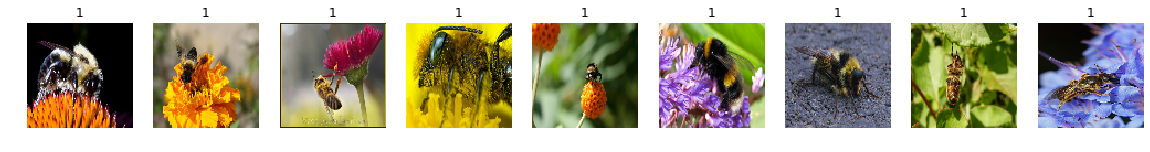

0


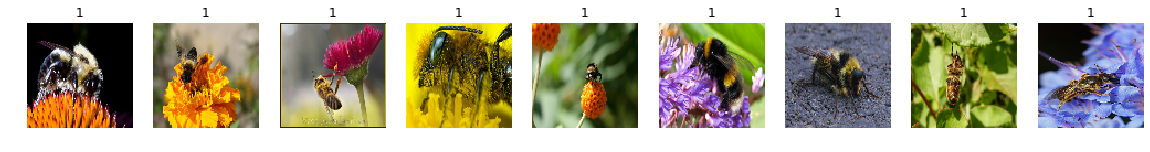

In [7]:
#如果显示有错，可以尝试使用np.reshape(thisimg, (size[0],size[1],3))或
#np.asarray(thisimg[0], dtype='uint8')改变类型与形状
def showresult(subplot,title,thisimg):          #显示单个图片
    p =plt.subplot(subplot)
    p.axis('off')
    p.imshow(thisimg)
    p.set_title(title)

def showimg(index,label,img,ntop):   #显示
    plt.figure(figsize=(20,10))     #定义显示图片的宽、高
    plt.axis('off')
    ntop = min(ntop,9)
    print(index)
    for i in range (ntop):
        showresult(100+10*ntop+1+i,label[i],img[i])
    plt.show()

def getone(dataset):
    iterator = dataset.make_one_shot_iterator()			#生成一个迭代器
    one_element = iterator.get_next()					#从iterator里取出一个元素
    return one_element

sample_dir=r"./hymenoptera_data/train"
size = [96,96]
batchsize = 10
tdataset = dataset(sample_dir,size,batchsize)
tdataset2 = dataset(sample_dir,size,batchsize,True)
print(tdataset.output_types)  #打印数据集的输出信息
print(tdataset.output_shapes)

one_element1 = getone(tdataset)				#从tdataset里取出一个元素
one_element2 = getone(tdataset2)				#从tdataset2里取出一个元素


with tf.Session() as sess:	# 建立会话（session）
    sess.run(tf.global_variables_initializer())  #初始化

    try:
        for step in np.arange(1):
            value = sess.run(one_element1)
            value2 = sess.run(one_element2)

            showimg(step,value[1],np.asarray( value[0]*255,np.uint8),10)       #显示图片
            showimg(step,value2[1],np.asarray( value2[0]*255,np.uint8),10)       #显示图片


    except tf.errors.OutOfRangeError:           #捕获异常
        print("Done!!!")
